# CSC3831 Final Assessment - Part I: Data Engineering



In [44]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
#added matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# for using in KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
# for MICE imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# for regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


In [45]:
#houses_corrupted.head(20)
houses_corrupted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


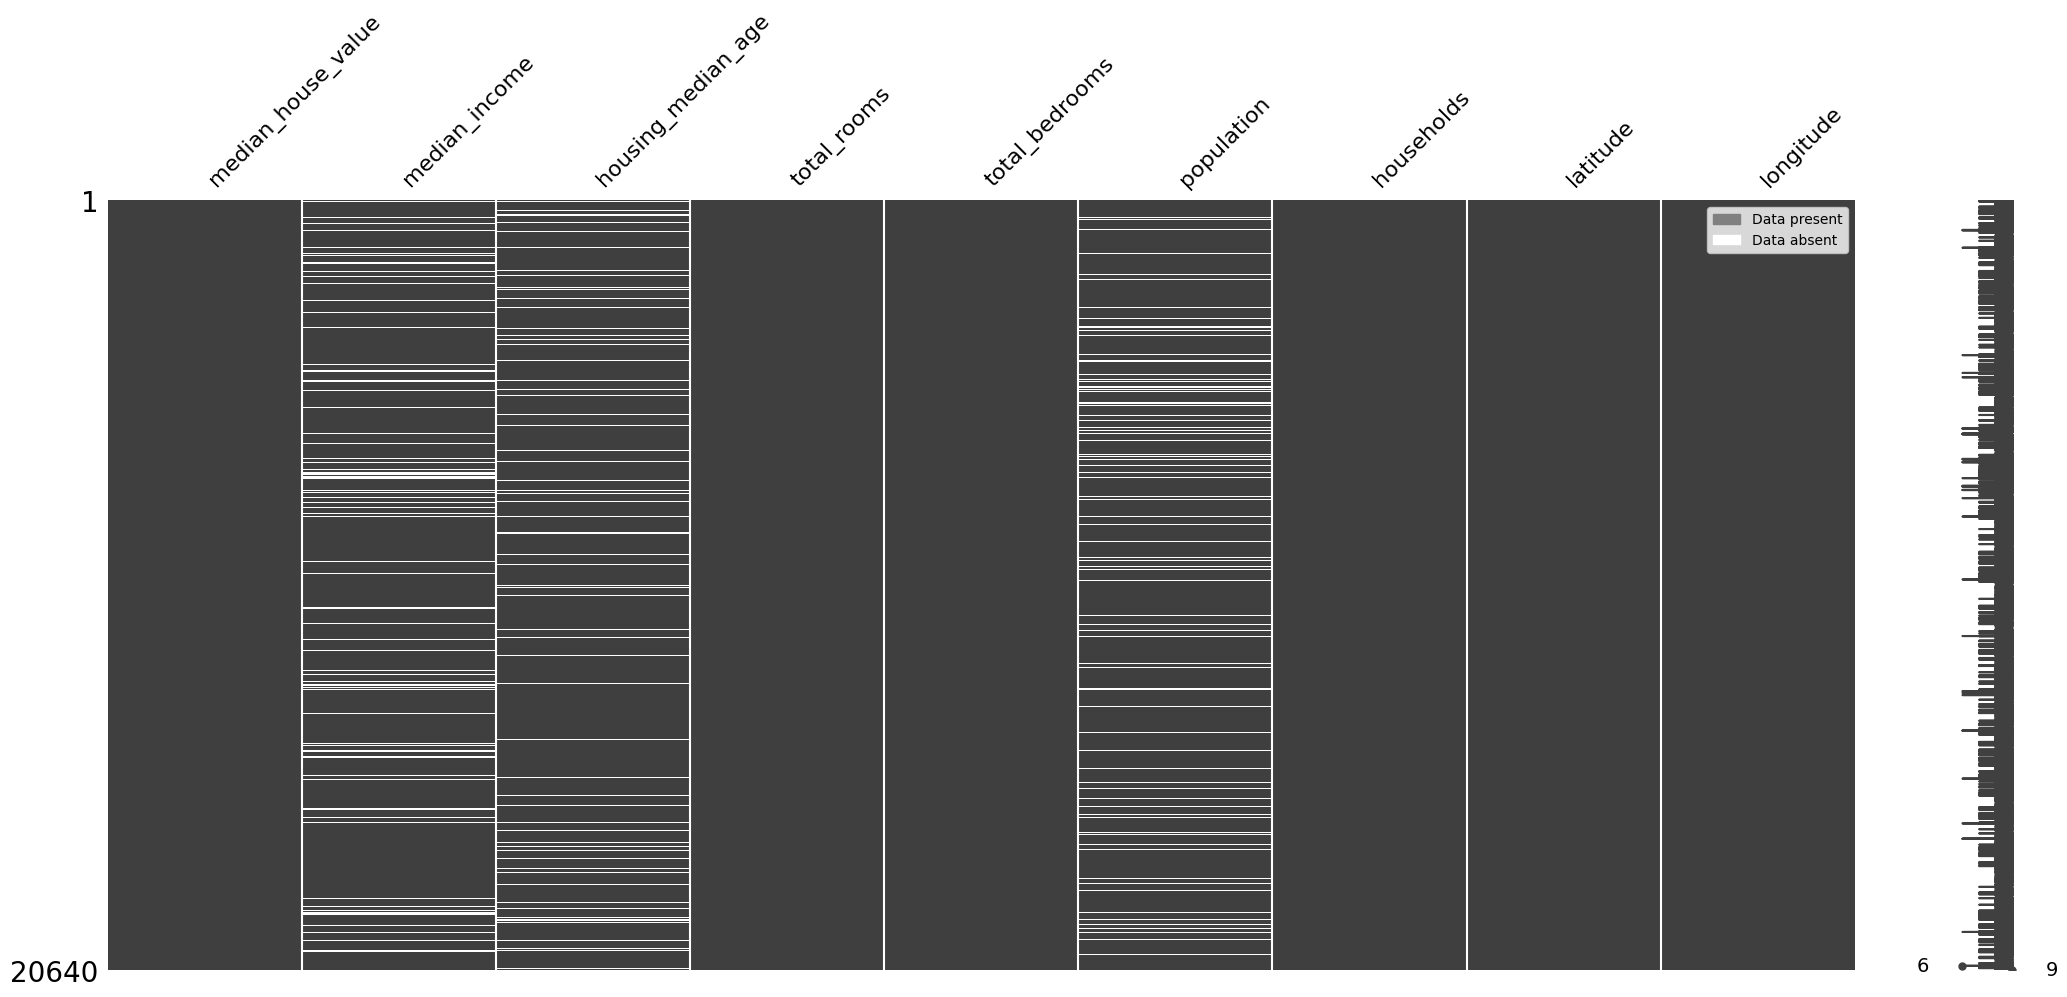

In [46]:
msno.matrix(houses_corrupted, )
gray_patch = mpatches.Patch(color='gray', label='Data present')
white_patch = mpatches.Patch(color='white', label='Data absent ')
plt.legend(handles=[gray_patch, white_patch])

plt.show()

In [47]:
print(len(houses_corrupted["population"]))

20640


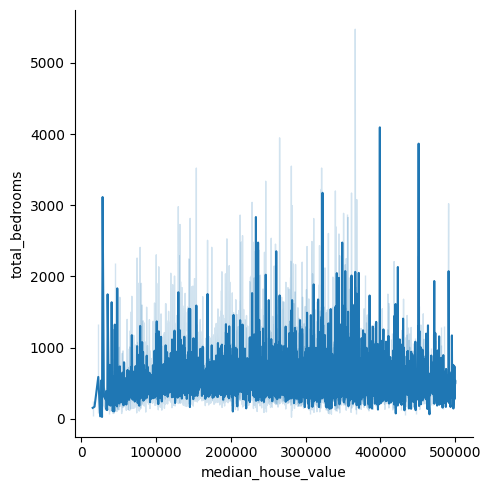

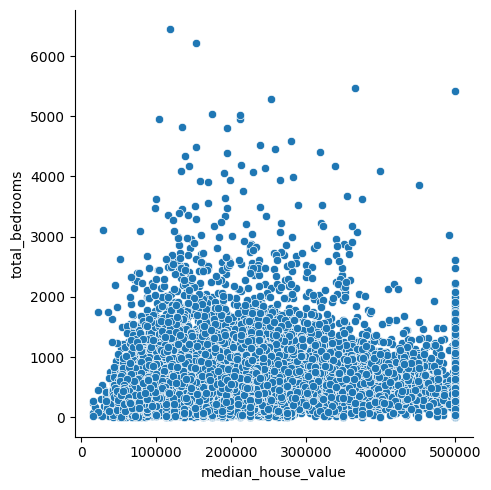

In [48]:
sns.relplot(houses_corrupted, x="median_house_value", y="total_bedrooms", kind="line")

sns.relplot(houses_corrupted, x="median_house_value", y="total_bedrooms")

<function matplotlib.pyplot.show(close=None, block=None)>

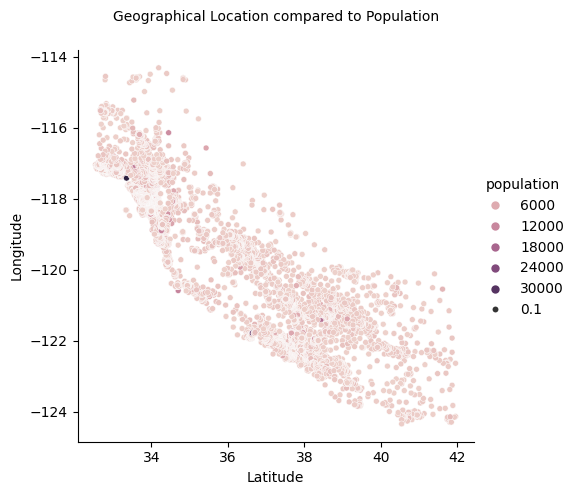

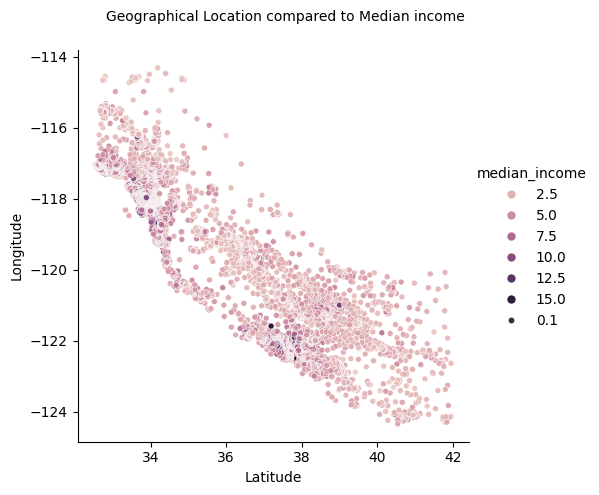

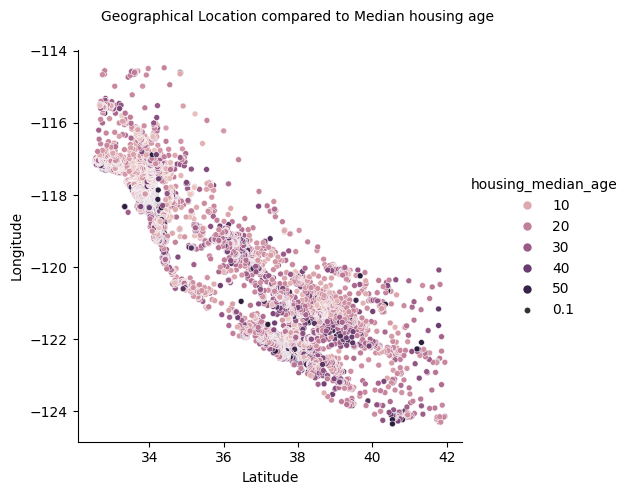

In [49]:
pop_plot = sns.relplot(houses_corrupted,x="latitude",y="longitude",hue="population", size=0.1)
pop_plot.set(xlabel='Latitude', ylabel='Longitude')
pop_plot.fig.suptitle('Geographical Location compared to Population', fontsize=10)
pop_plot.fig.subplots_adjust(top=0.9)
pop_plot.fig.tight_layout

income_plot = sns.relplot(houses_corrupted,x="latitude",y="longitude",hue="median_income", size=0.1)
income_plot.set(xlabel='Latitude', ylabel='Longitude')
income_plot.fig.suptitle('Geographical Location compared to Median income', fontsize=10)
income_plot.fig.subplots_adjust(top=0.9)
income_plot.fig.tight_layout

age_plot = sns.relplot(houses_corrupted,x="latitude",y="longitude",hue="housing_median_age", size=0.1)
age_plot.set(xlabel='Latitude', ylabel='Longitude')
age_plot.fig.suptitle('Geographical Location compared to Median housing age', fontsize=10)
age_plot.fig.subplots_adjust(top=0.9)
age_plot.fig.tight_layout

plt.show






### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


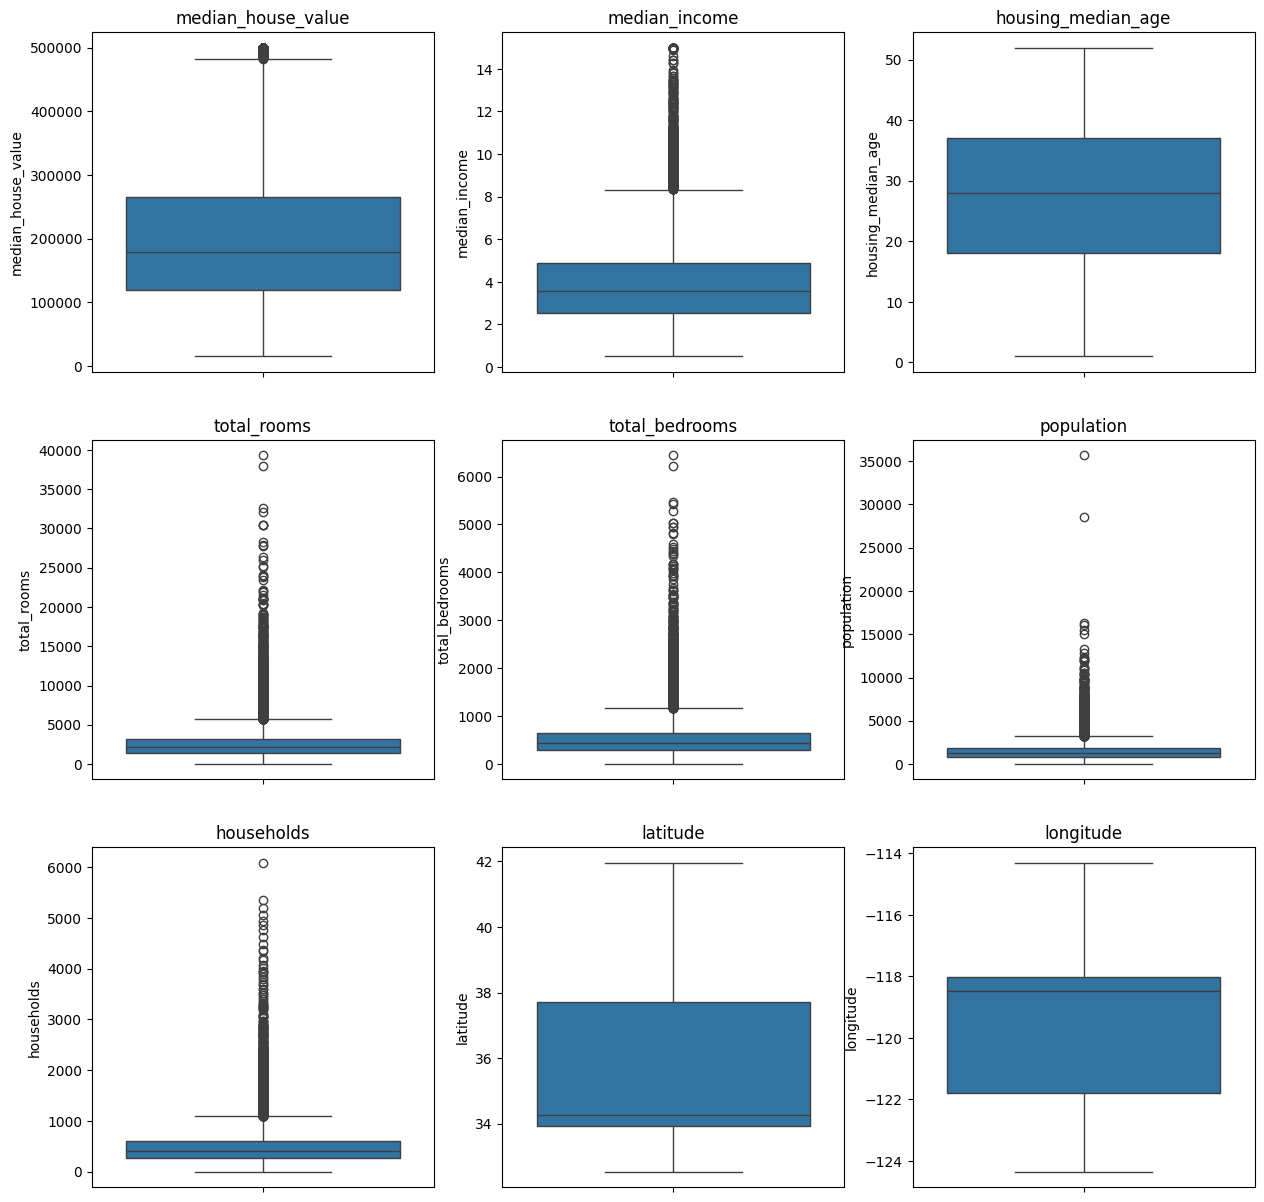

In [50]:

num_cols = houses_corrupted.shape[1]
rows = (num_cols // 3) + (num_cols % 3 > 0)
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for index in range(num_cols):
    sns.boxplot(houses_corrupted.iloc[:, index], ax=axes[index])
    axes[index].set_title(houses_corrupted.columns[index])

In [51]:
counter = 0
total = 0
for values in houses_corrupted["median_house_value"]:
  total = total + values
  counter +=1
print(total)
print(counter)
print(total/counter)

stand = houses_corrupted["median_house_value"].std()
mean = houses_corrupted["median_house_value"].mean()
print(stand)
print(mean)


4269504061.0
20640
206855.81690891474
115395.6158744132
206855.81690891474


206855.81690891474
115395.6158744132
-1.1016166445893026e-16
1.0000000000000138
Mean of median_house_value-1.1016166445893026e-16
Standard deviation of median_house_value1.0000000000000138


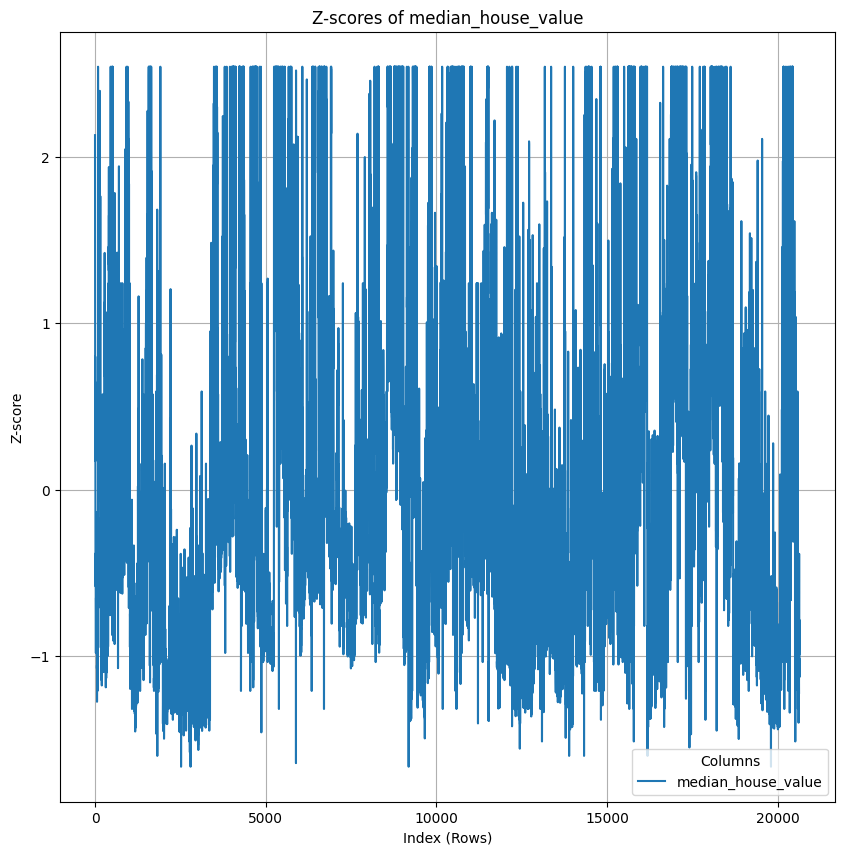

In [52]:
#print(houses_corrupted["population"].mean())
#print(houses_corrupted["population"].std())
df = houses_corrupted
print(houses_corrupted["median_house_value"].mean())
print(houses_corrupted["median_house_value"].std())
z_scores = (df - df.mean()) / df.std()
print(z_scores["median_house_value"].mean())
print(z_scores["median_house_value"].std())

print("Mean of median_house_value" + str(z_scores["median_house_value"].mean()))
print("Standard deviation of median_house_value" + str(z_scores["median_house_value"].std()))
plt.figure(figsize=(10, 10))

plt.plot(z_scores.index, z_scores["median_house_value"], label="median_house_value")

# Customizing the plot
plt.title("Z-scores of median_house_value")
plt.xlabel("Index (Rows)")
plt.ylabel("Z-score")
plt.legend(title="Columns")
plt.grid(True)
plt.show()




499.5396802325581
382.3297528316099
6082.0


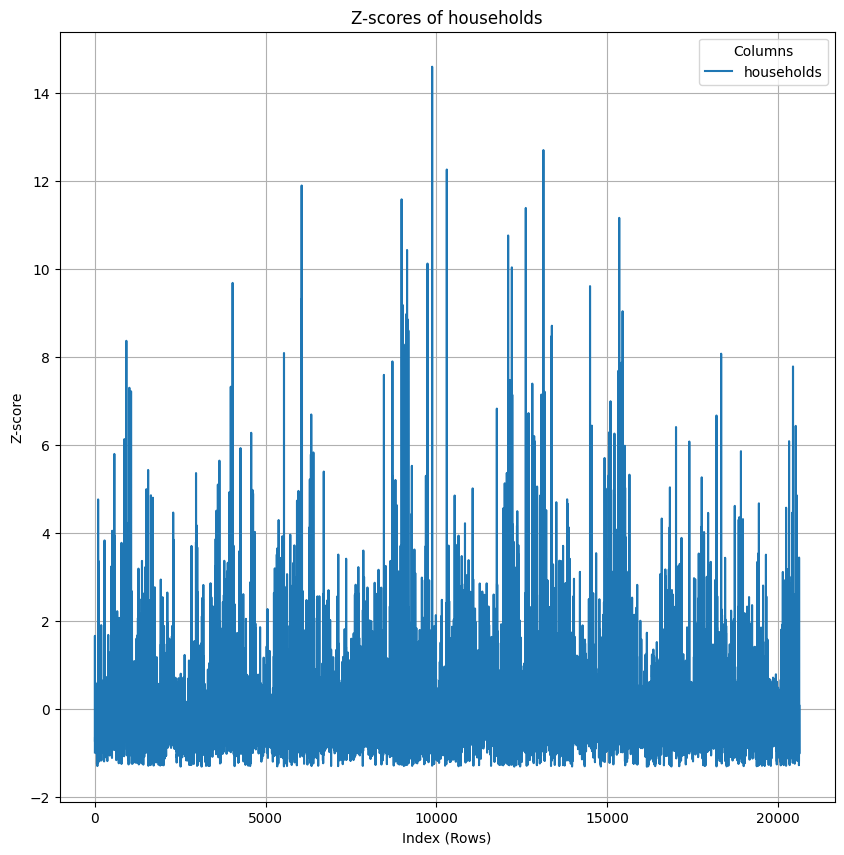

In [53]:
print(houses_corrupted["households"].mean())
print(houses_corrupted["households"].std())
max_value = 0
for values in houses_corrupted["households"]:
    if values > max_value:
        max_value = values
print(max_value)
min_value = 1000

plt.figure(figsize=(10, 10))

plt.plot(z_scores.index, z_scores["households"], label="households")

# Customizing the plot
plt.title("Z-scores of households")
plt.xlabel("Index (Rows)")
plt.ylabel("Z-score")
plt.legend(title="Columns")
plt.grid(True)
plt.show()

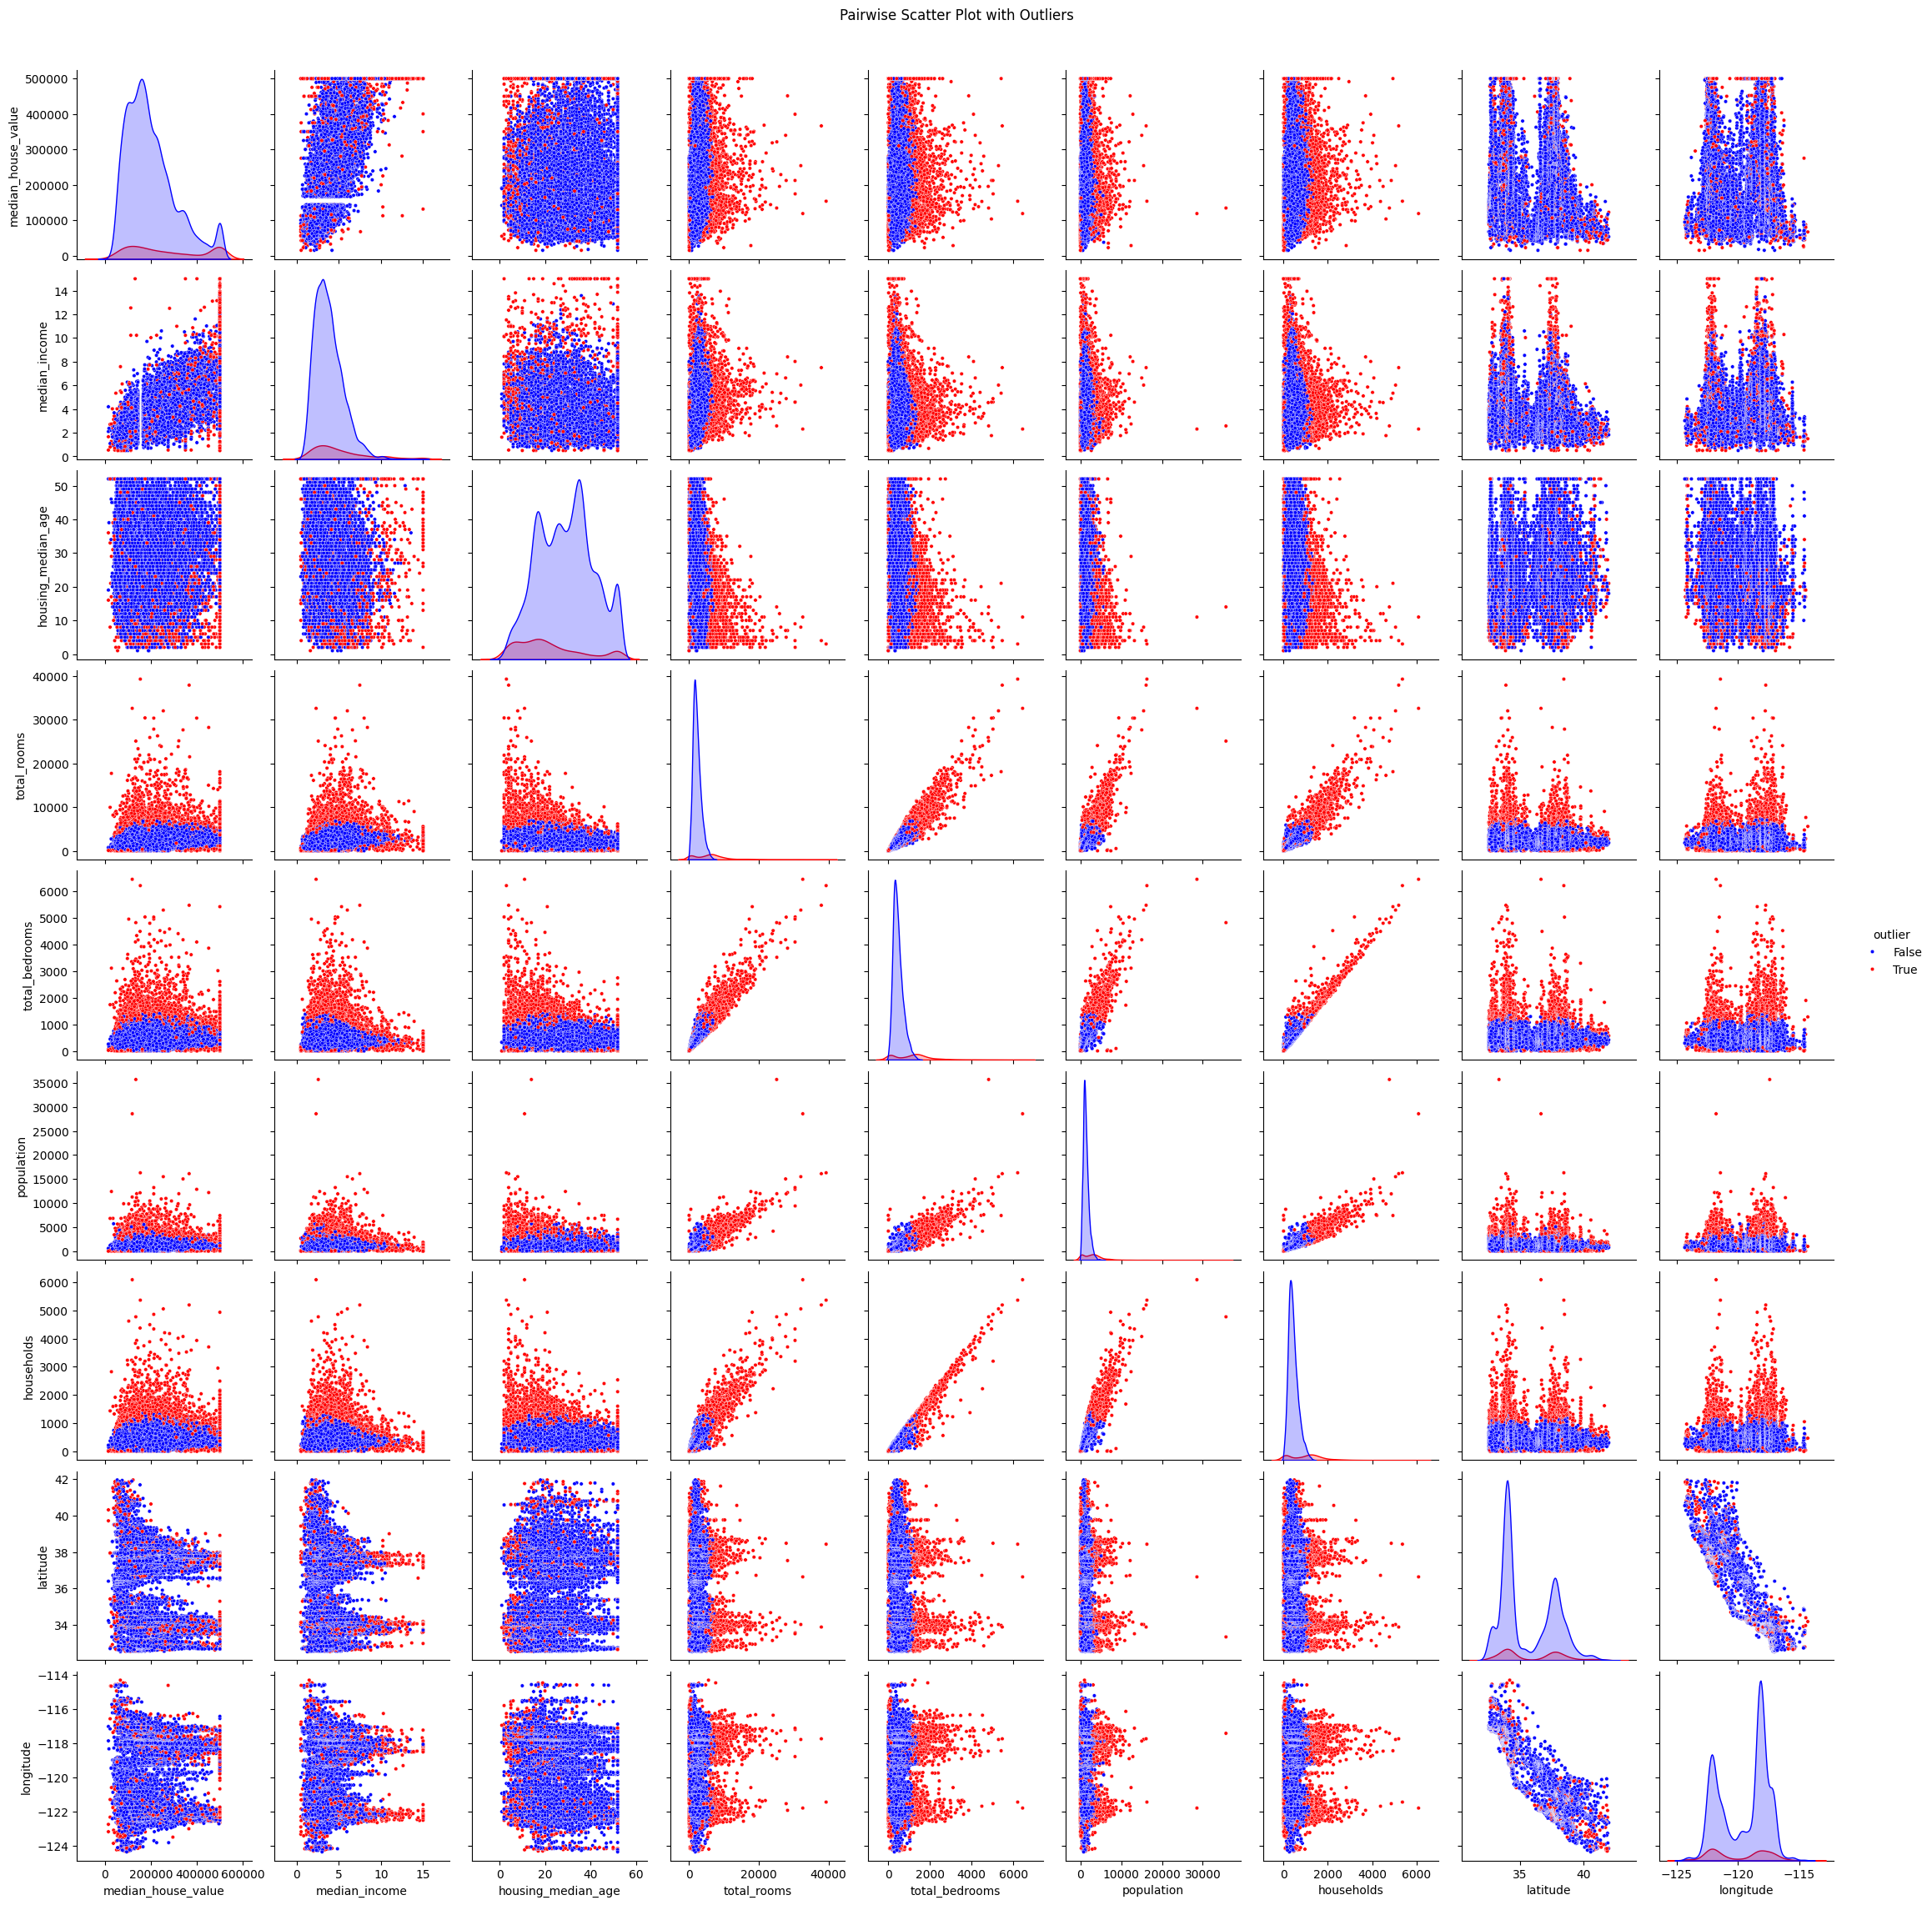

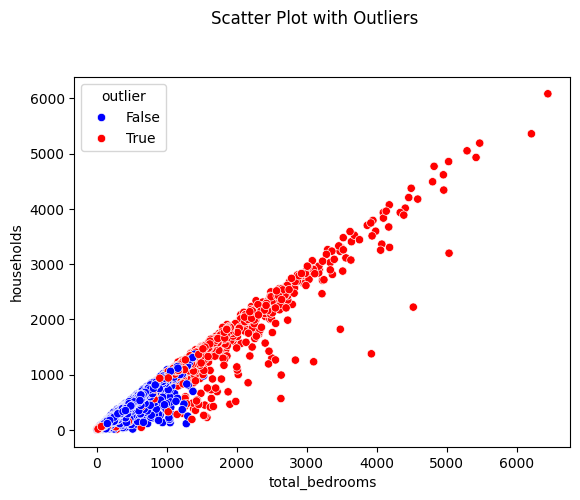

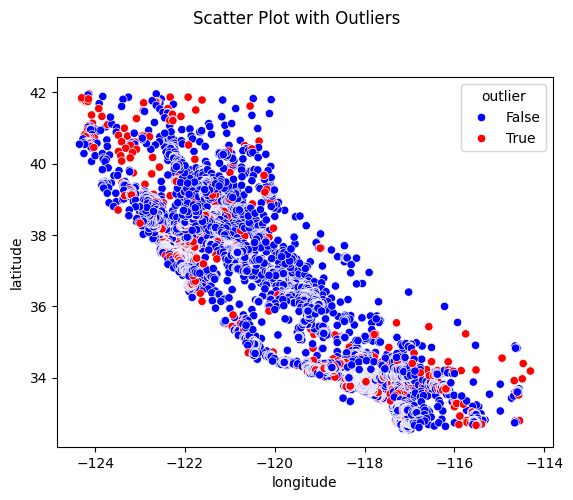

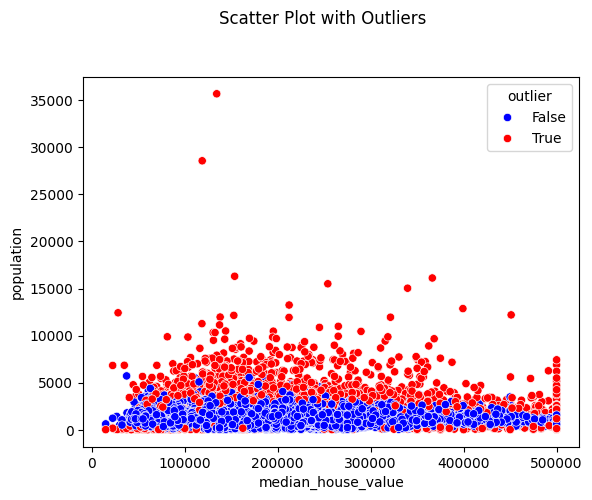

In [54]:

from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
clf = IsolationForest(n_estimators=100, max_samples=256, contamination=0.1)
y_pred = clf.fit_predict(houses_corrupted)
houses_corrupted["outlier"] = y_pred
houses_corrupted['outlier'] = houses_corrupted['outlier'] == -1
#print(houses_corrupted.head(20))
sns.pairplot(houses_corrupted, hue='outlier', palette={True: 'red', False: 'blue'}, plot_kws={'s': 10})
plt.suptitle('Pairwise Scatter Plot with Outliers', y=1.02)
plt.show()

sns.scatterplot(data=houses_corrupted, x='total_bedrooms', y='households', hue='outlier', palette={True: 'red', False: 'blue'})
plt.suptitle('Scatter Plot with Outliers', y=1.02)
plt.show()
sns.scatterplot(data=houses_corrupted, x='longitude', y='latitude', hue='outlier', palette={True: 'red', False: 'blue'})
plt.suptitle('Scatter Plot with Outliers', y=1.02)
plt.show()
sns.scatterplot(data=houses_corrupted, x='median_house_value', y='population', hue='outlier', palette={True: 'red', False: 'blue'})
plt.suptitle('Scatter Plot with Outliers', y=1.02)
plt.show()



### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [55]:
# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)
#remove all data that is an outlier from houses corrupted
houses_cleaned = houses_corrupted[houses_corrupted["outlier"] != True]
houses_cleaned = houses_cleaned.dropna(subset=['outlier'])
#drop outlier column

In [56]:
#finding the amount of data missing from columns with missing data
print(houses_cleaned["population"].isnull().sum())
print(houses_cleaned["housing_median_age"].isnull().sum())
print(houses_cleaned["median_income"].isnull().sum())
print((houses_cleaned["housing_median_age"].isnull().sum()/len(houses_cleaned["housing_median_age"])) * 100)
print((houses_cleaned["median_income"].isnull().sum()/len(houses_cleaned["median_income"])) * 100)
print((houses_cleaned["population"].isnull().sum()/len(houses_cleaned["population"])) * 100)

2035
2057
1952
11.073428079242033
10.508182601205856
10.954995693367787


In [57]:
#create a knn imputation method using a relevant number of neighbors
knn_imputer = KNNImputer(n_neighbors=3)
#use the imputer on my corrupted data to transform any Nan values to values like neighbors
houses_knn_imputed = knn_imputer.fit_transform(houses_cleaned)
#make the imputed data the same type of dataframe as the corrupted data
houses_knn_imputed = pd.DataFrame(houses_knn_imputed, columns=houses_cleaned.columns)

print(houses_knn_imputed.head(20))
print(houses_knn_imputed.info())



    median_house_value  median_income  housing_median_age  total_rooms  \
0             352100.0       7.257400           52.000000       1467.0   
1             341300.0       5.643100           52.000000       1274.0   
2             342200.0       3.846200           52.000000       1627.0   
3             269700.0       4.036800           52.000000        919.0   
4             299200.0       3.659100           52.000000       2535.0   
5             241400.0       3.120000           52.000000       3104.0   
6             226700.0       2.080400           42.000000       2555.0   
7             261100.0       3.691200           52.000000       3549.0   
8             281500.0       3.203100           34.333333       2202.0   
9             241800.0       3.270500           52.000000       3503.0   
10            213500.0       3.075000           52.000000       2491.0   
11            191300.0       2.673600           52.000000        696.0   
12            159200.0       2.577900 

In [58]:
#using MICE
#replace all missing values with appropriate values e.i mean values
imputer = IterativeImputer(random_state=100, max_iter=10, verbose=10)
#verbose allows to see if the tolerance difference has changed and should be very small after a few operations
imputer.fit(houses_cleaned)
houses_mice_imputed = imputer.transform(houses_cleaned)
houses_mice_imputed = pd.DataFrame(houses_mice_imputed, columns=houses_cleaned.columns)
print(houses_mice_imputed.head(20))

[IterativeImputer] Completing matrix with shape (18576, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.72
[IterativeImputer] Change: 1496.391037653796, scaled tolerance: 500.00100000000003 
[IterativeImputer] Ending imputation round 2/10, elapsed time 1.41
[IterativeImputer] Change: 9.436131200100135, scaled tolerance: 500.00100000000003 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (18576, 10)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.02
    median_house_value  median_income  housing_median_age  total_rooms  \
0             352100.0       7.257400           52.000000       1467.0   
1             341300.0       5.643100           52.000000       1274.0   
2             342200.0       3.846200           52.000000       1627.0   
3             269700.0       4.036800           52.000000        919.0   
4             299200.0 

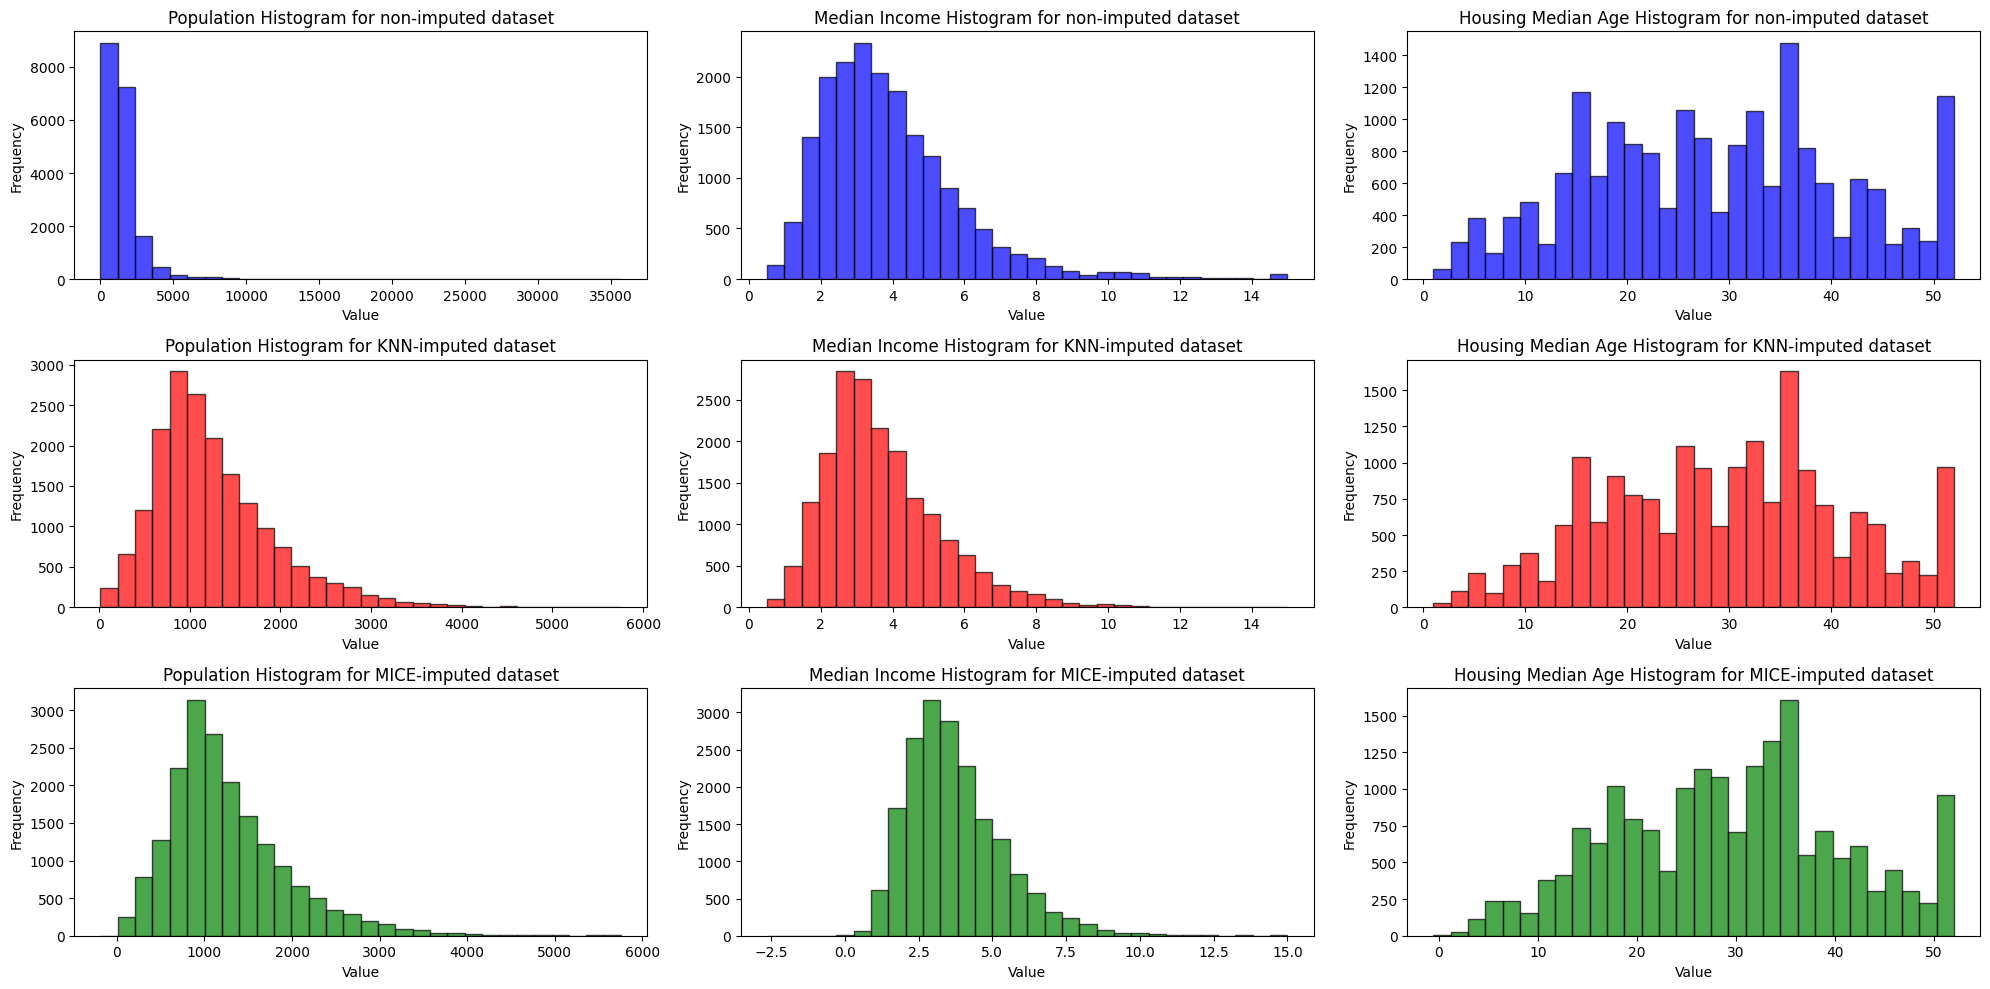

In [59]:
#building histograms for each dataset to compare distribution of the columns with missing elements once computed
fig, axis = plt.subplots(3,3, figsize=(20,10))
axis[0,0].hist(houses_corrupted['population'], bins=30, color='blue', edgecolor='black', alpha=0.7)
axis[0,0].set_title("Population Histogram for non-imputed dataset")
axis[0,0].set_xlabel("Value")
axis[0,0].set_ylabel("Frequency")
axis[0,1].hist(houses_corrupted['median_income'], bins=30, color='blue', edgecolor='black', alpha=0.7)
axis[0,1].set_title("Median Income Histogram for non-imputed dataset")
axis[0,1].set_xlabel("Value")
axis[0,1].set_ylabel("Frequency")
axis[0,2].hist(houses_corrupted['housing_median_age'], bins=30, color='blue', edgecolor='black', alpha=0.7)
axis[0,2].set_title("Housing Median Age Histogram for non-imputed dataset")
axis[0,2].set_xlabel("Value")
axis[0,2].set_ylabel("Frequency")
axis[1,0].hist(houses_knn_imputed['population'], bins=30, color='red', edgecolor='black', alpha=0.7)
axis[1,0].set_title("Population Histogram for KNN-imputed dataset")
axis[1,0].set_xlabel("Value")
axis[1,0].set_ylabel("Frequency")
axis[1,1].hist(houses_knn_imputed['median_income'], bins=30, color='red', edgecolor='black', alpha=0.7)
axis[1,1].set_title("Median Income Histogram for KNN-imputed dataset")
axis[1,1].set_xlabel("Value")
axis[1,1].set_ylabel("Frequency")
axis[1,2].hist(houses_knn_imputed['housing_median_age'], bins=30, color='red', edgecolor='black', alpha=0.7)
axis[1,2].set_title("Housing Median Age Histogram for KNN-imputed dataset")
axis[1,2].set_xlabel("Value")
axis[1,2].set_ylabel("Frequency")
axis[2,0].hist(houses_mice_imputed['population'], bins=30, color='green', edgecolor='black', alpha=0.7)
axis[2,0].set_title("Population Histogram for MICE-imputed dataset")
axis[2,0].set_xlabel("Value")
axis[2,0].set_ylabel("Frequency")
axis[2,1].hist(houses_mice_imputed['median_income'], bins=30, color='green', edgecolor='black', alpha=0.7)
axis[2,1].set_title("Median Income Histogram for MICE-imputed dataset")
axis[2,1].set_xlabel("Value")
axis[2,1].set_ylabel("Frequency")
axis[2,2].hist(houses_mice_imputed['housing_median_age'], bins=30, color='green', edgecolor='black', alpha=0.7)
axis[2,2].set_title("Housing Median Age Histogram for MICE-imputed dataset")
axis[2,2].set_xlabel("Value")
axis[2,2].set_ylabel("Frequency")
plt.tight_layout()
plt.show()


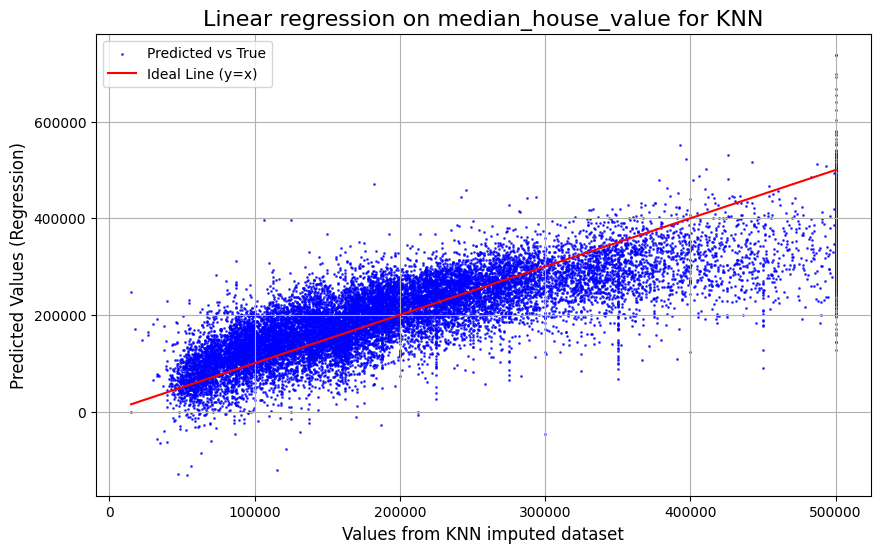

r^2 score: 0.6496376880165561
MAE: 47064.19461778127
MSE: 4049069714.898213
RMRE: 63632.30087697767


In [60]:
#building a linear regression model to compare the imputed data
#, houses_mice_imputed.drop('median_house_value', axis=1),houses.drop('median_house_value', axis=1)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error

X = pd.concat([houses_knn_imputed.drop('median_house_value', axis=1)], axis=1)
y = houses_knn_imputed['median_house_value']
regressor = LinearRegression()
regressor.fit(X, y)

y_pred = regressor.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs True', alpha=0.7, s=1)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Ideal Line (y=x)')

plt.title('Linear regression on median_house_value for KNN', fontsize=16)
plt.xlabel('Values from KNN imputed dataset', fontsize=12)
plt.ylabel('Predicted Values (Regression)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
print('r^2 score: ' + str(r2_score(y, y_pred)))
print('MAE: ' + str(mean_absolute_error(y, y_pred)))
print('MSE: ' + str(mean_squared_error(y, y_pred)))
print('RMRE: ' + str(np.sqrt(mean_squared_error(y, y_pred))))



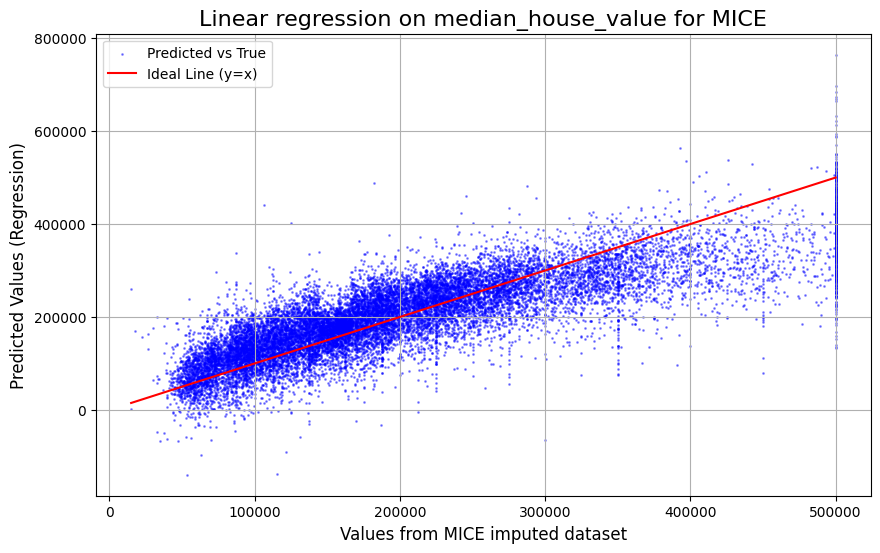

r^2 score: 0.6663808837250014
MAE: 45761.00796353153
MSE: 3855571828.9815245
RMRE: 62093.251074344014


In [61]:
X = pd.concat([houses_mice_imputed.drop('median_house_value', axis=1)], axis=1)
y = houses_mice_imputed['median_house_value']
regressor = LinearRegression()
regressor.fit(X, y)

y_pred = regressor.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs True', alpha=0.4, s=1)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Ideal Line (y=x)')

plt.title('Linear regression on median_house_value for MICE', fontsize=16)
plt.xlabel('Values from MICE imputed dataset', fontsize=12)
plt.ylabel('Predicted Values (Regression)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

print('r^2 score: ' + str(r2_score(y, y_pred)))
print('MAE: ' + str(mean_absolute_error(y, y_pred)))
print('MSE: ' + str(mean_squared_error(y, y_pred)))
print('RMRE: ' + str(np.sqrt(mean_squared_error(y, y_pred))))

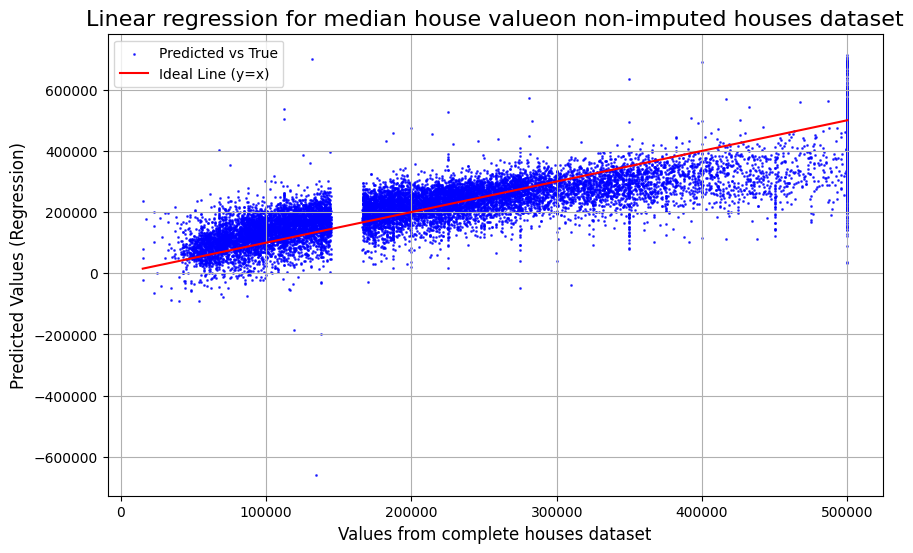

r^2 score: 0.6479234340537077
MAE: 52076.669260940806
MSE: 5043297779.387363
RMRE: 71016.17970144103


In [62]:
# for building a regressor on the non-imputed dataframe (houses_corrupted all Nan data so regression can be ran)#
Na_free_houses = houses_corrupted.dropna()
X = pd.concat([Na_free_houses.drop('median_house_value', axis=1)], axis=1)
y = Na_free_houses['median_house_value']
regressor = LinearRegression()
regressor.fit(X, y)

y_pred = regressor.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs True', alpha=0.7, s=1)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Ideal Line (y=x)')

plt.title('Linear regression for median house valueon non-imputed houses dataset', fontsize=16)
plt.xlabel('Values from complete houses dataset', fontsize=12)
plt.ylabel('Predicted Values (Regression)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

print('r^2 score: ' + str(r2_score(y, y_pred)))
print('MAE: ' + str(mean_absolute_error(y, y_pred)))
print('MSE: ' + str(mean_squared_error(y, y_pred)))
print('RMRE: ' + str(np.sqrt(mean_squared_error(y, y_pred))))

### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation